In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

## Generating a mixture of signals

We will generate a mixture of signals of 60 seconds with varying frequencies:

s(t) = s1(t) + s2(t) + s3(t) + noise

We will start with 3 frequencies: 30 bpm, 60 bpm and 90 bpm
Each of the three signal's frequency will vary with time
Plus we will add gaussian noise


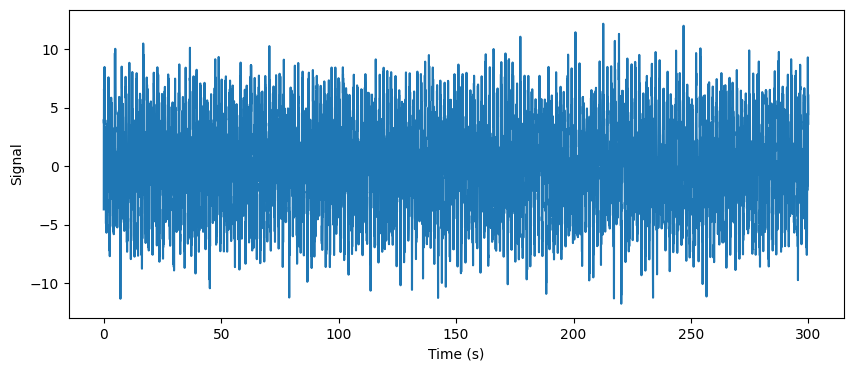

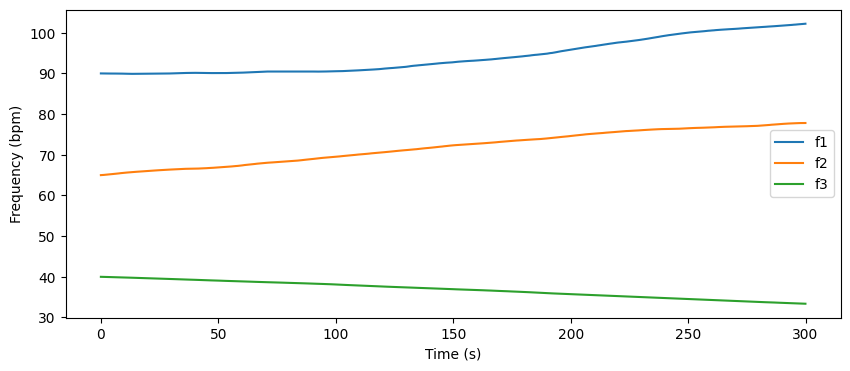

In [2]:
sample_time = 300
sample_rate = 30
n_sample = sample_time * sample_rate
dt = 1/sample_rate
sig = np.zeros(n_sample)

p1, p2, p3 = 1, 2, 4 # amplitude
pn = 2 # noise amplitude
f1, f2, f3 = 90, 65, 40 # initial frequency (bpm)
min_freq, max_freq = 5, 200
angle1, angle2, angle3 = 0, 0, 0 # initial theta (radian)
u1, u2, u3 = 0, 0.003, -0.001 # 1st order derivative of f1, f2, f3
a1, a2, a3 = 0.001, 0.001, 0.0001 # 2nd order derivative of f1, f2, f3

f1s, f2s, f3s = np.zeros(n_sample), np.zeros(n_sample), np.zeros(n_sample) # instant frequency


def process_next_sample(i, p, f, angle, u, a, fs):
    global sig, sample_rate, dt

    angle += 2 * np.pi * (f/60) * dt
    sig[i] += p * np.sin(angle)
    fs[i] = f
    f += u*np.random.random(1)
    if i%(sample_rate//2) == 0: # change frequency slope after 0.5 seconds
        u += (a*np.random.random(1) - a/2)
    return np.clip(f, min_freq, max_freq), angle, u

for i in range(n_sample):
    f1, angle1, u1 = process_next_sample(i, p1, f1, angle1, u1, a1, f1s)
    f2, angle2, u2 = process_next_sample(i, p2, f2, angle2, u2, a2, f2s)
    f3, angle3, u3 = process_next_sample(i, p3, f3, angle3, u3, a3, f3s)
    sig[i] += np.random.normal(0,pn)

plt.figure(figsize=(10,4), dpi=100)
plt.plot(np.arange(n_sample)/sample_rate, sig)
plt.xlabel('Time (s)')
plt.ylabel('Signal')

plt.figure(figsize=(10,4), dpi=100)
plt.plot(np.arange(n_sample)/sample_rate, f1s, label='f1')
plt.plot(np.arange(n_sample)/sample_rate, f2s, label='f2')
plt.plot(np.arange(n_sample)/sample_rate, f3s, label='f3')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (bpm)')
plt.legend(loc='best')
plt.show()


### Functions we will use for plotting

In [3]:
def plot_sprectogram(spectrogram, spec_time, spec_freq , title=''):
    n_frq = spectrogram.shape[0]
    spec_freq_grid = np.linspace(spec_freq[0], spec_freq[1], n_frq)
    plt.figure(figsize=(8, 4), dpi=80)
    plt.pcolormesh(spec_time[:,0]*60, spec_freq_grid, spectrogram, cmap='jet', shading='auto')
    plt.ylabel('Frequency (bpm)')
    plt.xlabel('Time [sec]')
    plt.title(title)

def plot_time_vs_freq(f_time, freq):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (bpm)')
    ax.plot(f_time, freq, label='AMTC estimated frequency')
    ax.legend()
    ax.grid()

### Functions for calling Robust Frequency Tracking Algorithm from server

In [4]:
def amtc_freq_from_signal(sig,
                          fps,
                          freq_limit,
                          window_length_in_sec=10,
                          overlap_percent=98,
                          nfft=2048,
                          smoothness=1.0,
                          notch_switch=False,
                          notch_in_nbins=3,
                          preprocess_switch=True,
                          preprocess_k=2,
                          preprocess_accum=False,
                          label='Frequency (bpm)'):

    url = 'https://amtc-i3bncenngq-uc.a.run.app/amtc-signal'

    send_dic = {
        "signal": sig.tolist(),
        "window_length_in_sec": window_length_in_sec,
        "overlap":overlap_percent/100,
        "sample_per_sec": fps,
        "preprocess_k": preprocess_k,
        "preprocess_switch": preprocess_switch,
        "preprocess_accum": preprocess_accum,
        "freq_limit": freq_limit,
        "label": label,
        "notch_switch": notch_switch,
        "notch_in_nbins": notch_in_nbins,
        "nfft": nfft,
        "smoothness": smoothness
    }

    # curl -X POST https://process---amtc-i3bncenngq-uc.a.run.app/amtc-processed -H 'Content-Type: application/json' -d '{"signal":[1,-1,1,-1,1],"fps":2,"freq_limit":[30,90]}'

    x = requests.post(url, json=send_dic)
    x_as_dic = json.loads(x.text)

    spec_res = np.array(x_as_dic["spec_rgb"],
                        dtype=np.uint8)  # uint8 image sent
    rec_time = np.array(x_as_dic["time"], dtype=np.float32)
    rec_est = np.array(x_as_dic["est"], dtype=np.float32)

    spec = np.array(x_as_dic["spec"], dtype=np.float32)  # uint8 image sent
    spec_time = np.array(x_as_dic["spec_time"], dtype=np.float32)
    spec_freq = np.array(x_as_dic["spec_freq"], dtype=np.float32)

    return spec_res, rec_time, rec_est, spec, spec_time, spec_freq


def amtc_freq_from_spectrogram(spec, spec_time, spec_freq, delay, notch_switch,
                               notch_in_nbins=4, smoothness=1.0):

    url = 'https://amtc-i3bncenngq-uc.a.run.app/amtc-spectrogram'

    send_dic = {
        "spec": spec.tolist(),
        "spec_time": spec_time.tolist(),
        "spec_freq": spec_freq.tolist(),
        "delay": delay,
        "smoothness": smoothness,
        "notch_switch": notch_switch,
        "notch_in_nbins": notch_in_nbins,
    }

    x = requests.post(url, json=send_dic)
    x_as_dic = json.loads(x.text)

    spec_rgb = np.array(x_as_dic["spec_rgb"],
                        dtype=np.uint8)  # uint8 image sent
    rec_time = np.array(x_as_dic["time"],
                        dtype=np.float32)  # amtc_process time (5 fps)
    rec_est = np.array(x_as_dic["est"], dtype=np.float32)
    notched = np.array(x_as_dic["notched"], dtype=np.float32)

    tm, hr_remote = rec_time, rec_est

    return spec_rgb, tm, hr_remote, notched


## Run from google cloud

### Get 1st first frequency trace

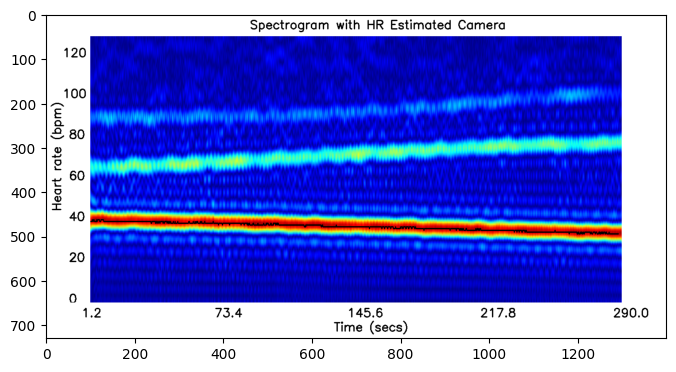

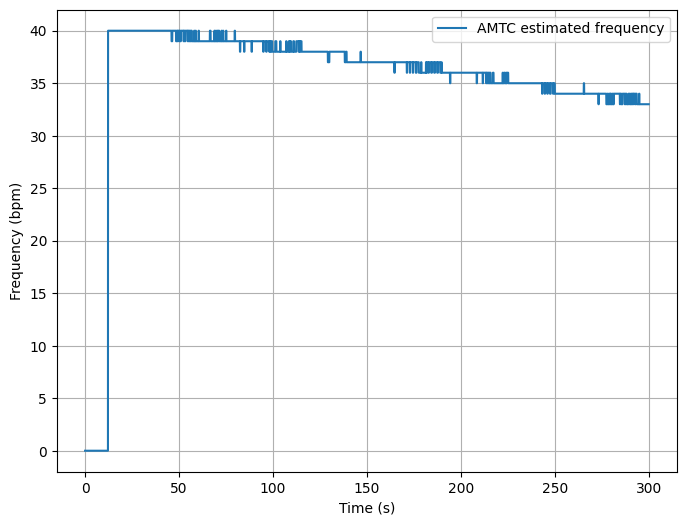

In [5]:
spec_rgb, rec_time, rec_est, spectrogram2, spec_time, spec_freq = amtc_freq_from_signal(sig, sample_rate, [0,130],
                                                                              window_length_in_sec=10, overlap_percent=98,nfft=2048,
                                                                              smoothness=1.0, notch_switch=True, notch_in_nbins=7,
                                                                              preprocess_switch=True,preprocess_k=2,preprocess_accum=True)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(spec_rgb)

plot_time_vs_freq(rec_time, rec_est)

#plot_sprectogram(spectrogram2, spec_time, spec_freq, "Detected frequency notched")

### Get second frequency trace

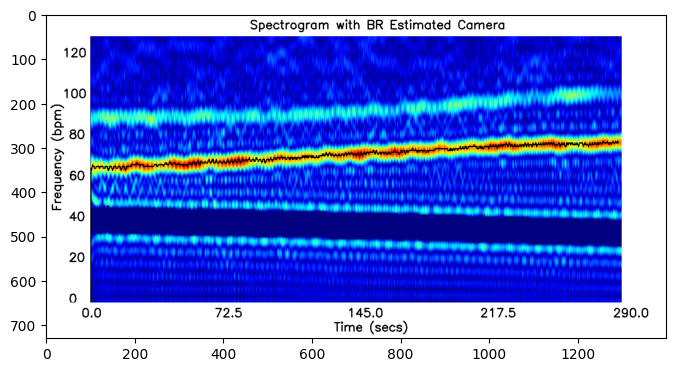

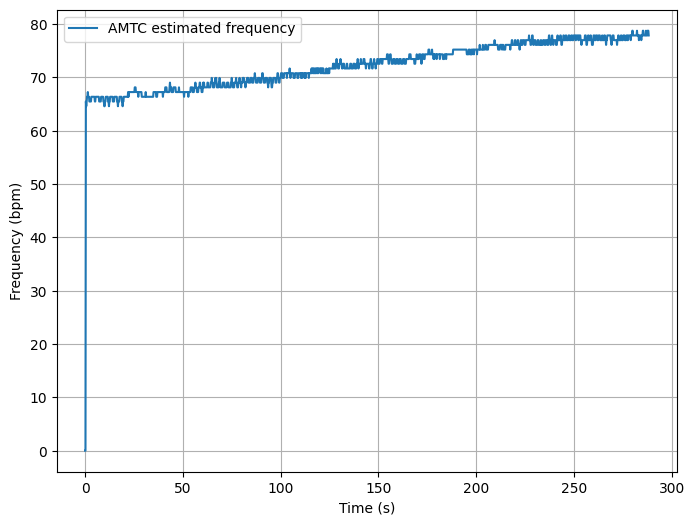

In [6]:
spec_res, rec_time, rec_est, spectrogram3 = amtc_freq_from_spectrogram(spectrogram2, spec_time, spec_freq, delay=0, notch_switch=True, notch_in_nbins=5)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(spec_res)

plot_time_vs_freq(rec_time, rec_est)

#plot_sprectogram(spectrogram3, spec_time, spec_freq, "Detected frequency notched")

## Get third frequency trace

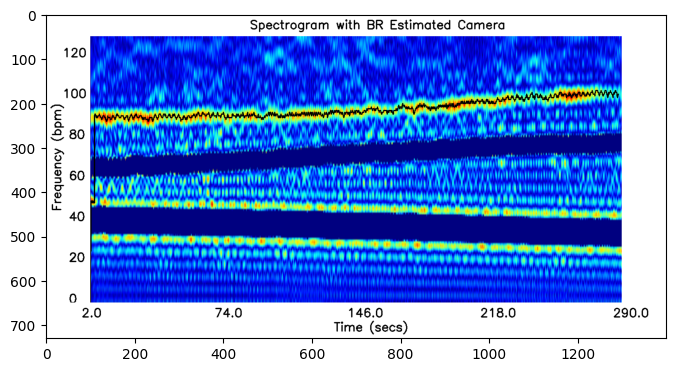

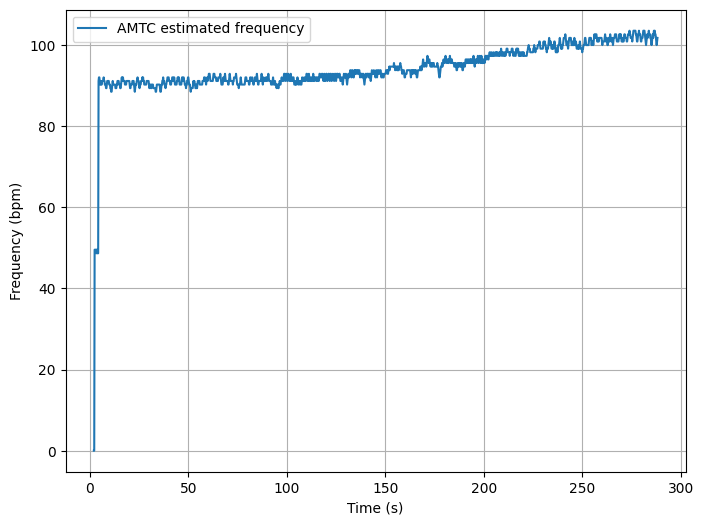

In [7]:
spec_res, rec_time, rec_est, _ = amtc_freq_from_spectrogram(spectrogram3, spec_time, spec_freq, delay=2, notch_switch=False)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(spec_res)

plot_time_vs_freq(rec_time, rec_est)